# Workshop 5


---


Andrea Medina Rico

A01705541

11.11.2025

## 1. Hand-on activity

Este es un ejercicio de clase realizado para familiarizarse con los conceptos, por lo que nada viene explicado en todo este apartado.

### 1.1 Data collection and management

In [1]:
!pip install statsmodels 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 191.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 56.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import requests
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
# Code to download the IGAE index from the INEGI site:
token = 'c4559227-83d3-aeb4-1a8d-bee73f627140'
igae_id = '737121'
url =  f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{igae_id}/es/0700/false/BIE/2.0/{token}?type=json'

response = requests.get(url)
data = response.json()
series = data.get('Series', [])
observations = series[0].get('OBSERVATIONS', [])

igaedf = pd.DataFrame(observations)

In [4]:
# Convert the month to a date type variable:
igaedf['TIME_PERIOD'] = pd.to_datetime(igaedf['TIME_PERIOD'], format='%Y/%m')

# Convert the IGAE index to a numeric variable:
igaedf['OBS_VALUE'] = pd.to_numeric(igaedf['OBS_VALUE'], errors='coerce')

# Keep only the columns we need
igaedf = igaedf[['TIME_PERIOD', 'OBS_VALUE']]

# Rename the columns:
igaedf.columns = ['Month', 'IGAE']

# Setting the month as the index of the series:
igaedf = igaedf.set_index('Month')

# Sorting the data according to the index:
igaedf = igaedf.sort_index()
igaedf.head(5)

,IGAE
Month,
1993-01-01,55.434736
1993-02-01,56.456971
1993-03-01,58.900549
1993-04-01,57.135844
1993-05-01,57.891853


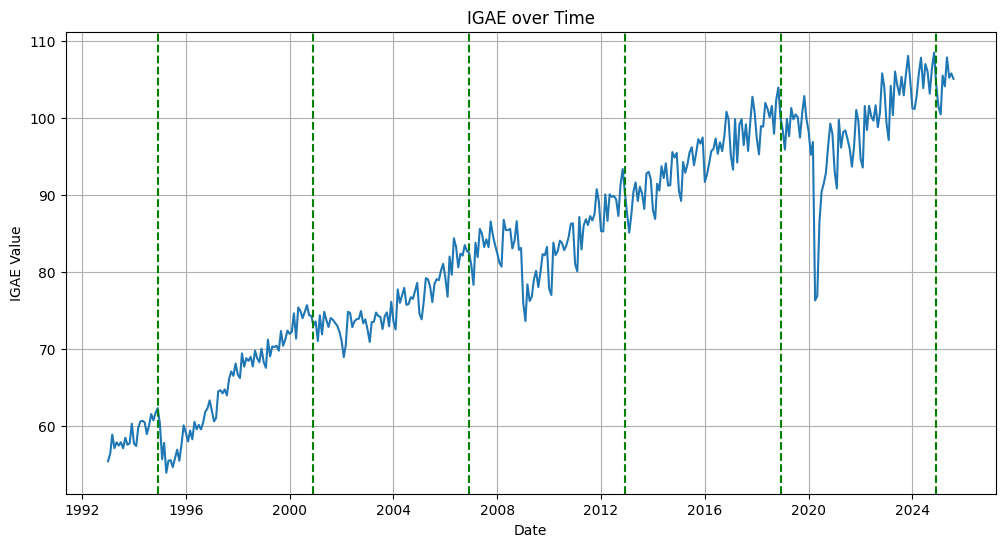

In [5]:
# prompt: plot the IGAE from df, and trace a vertical line in Dec 2018 and Dec 2024

import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, igaedf['IGAE'])
plt.title('IGAE over Time')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)

# Trace vertical lines to identify the 6-year government periods
plt.axvline(pd.to_datetime('1994-12-01'), color='green', linestyle='--')
plt.axvline(pd.to_datetime('2000-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2006-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2012-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2018-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2024-12-01'), color='green',linestyle='--')

plt.show()

### 1.2. Stationary vs. Non-stationary

Percentual change per month overtime

Seasonal (yearly) --> annual percentual change

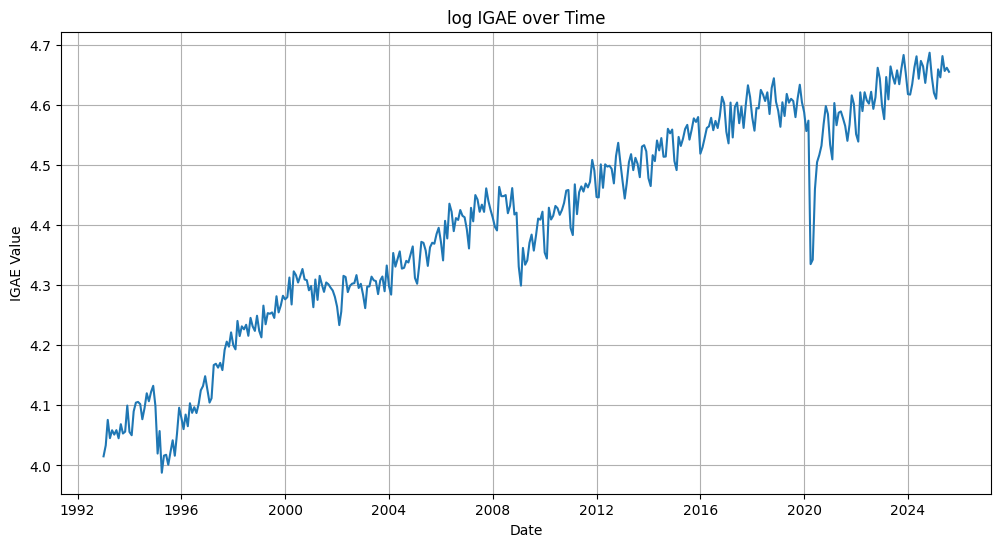

In [6]:
igaedf['logIGAE'] = np.log(igaedf['IGAE'])

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, igaedf['logIGAE'])
plt.title('log IGAE over Time')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)
plt.show()

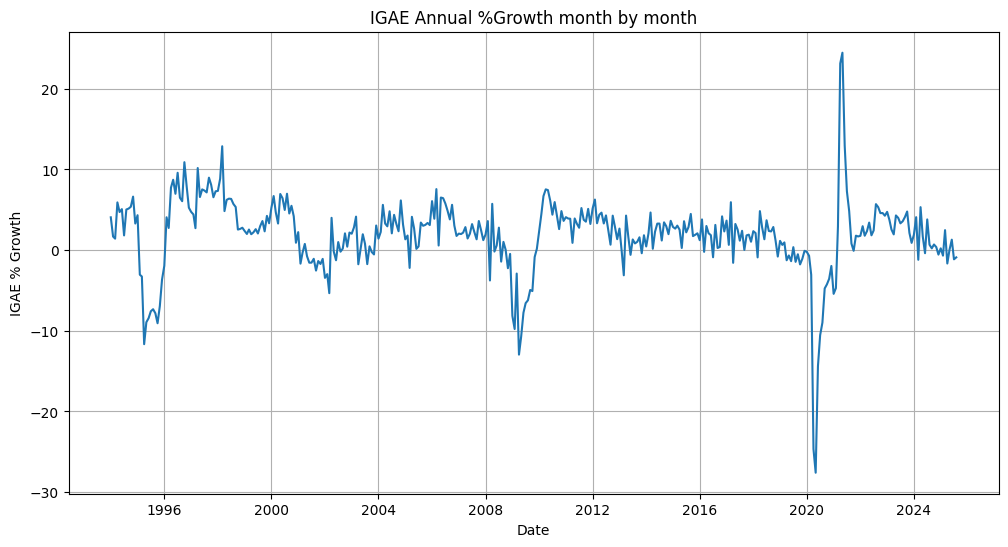

In [7]:
igaedf['annualgrowth'] = igaedf['logIGAE'] - igaedf['logIGAE'].shift(12)
# We can also do this annual growth by using the diff function:
# igaedf['annualgrowth2'] = igaedf['logIGAE'].diff(12)

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, 100*igaedf['annualgrowth'])
plt.title('IGAE Annual %Growth month by month')
plt.xlabel('Date')
plt.ylabel('IGAE % Growth')
plt.grid(True)
plt.show()

Debido a que el *p-value = 0.001*, se rechaza la hipótesis nula y se decreta que el annual percentual change es **stationary**.

In [8]:
dftest = adfuller(igaedf['annualgrowth'].dropna())
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])

print('Critical Values:')
for key, value in dftest[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.962962
p-value: 0.001617
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


### 1.3. Autocorrelations (AC) and Partial Autocorrelations (PAC)

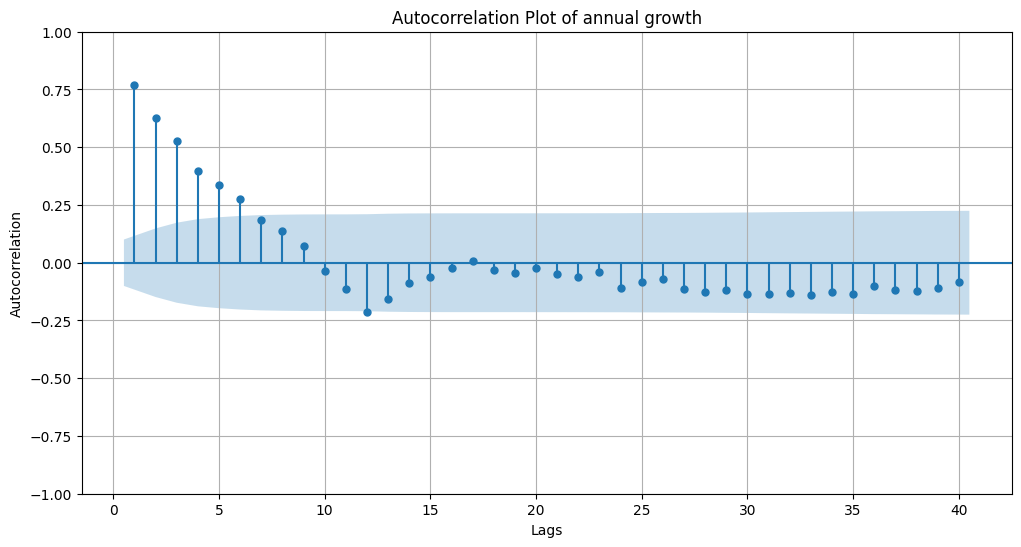

In [9]:
# Drop NaN values created by the differencing
annual_growth = igaedf.dropna(subset=['annualgrowth'])

# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(annual_growth['annualgrowth'], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of annual growth')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

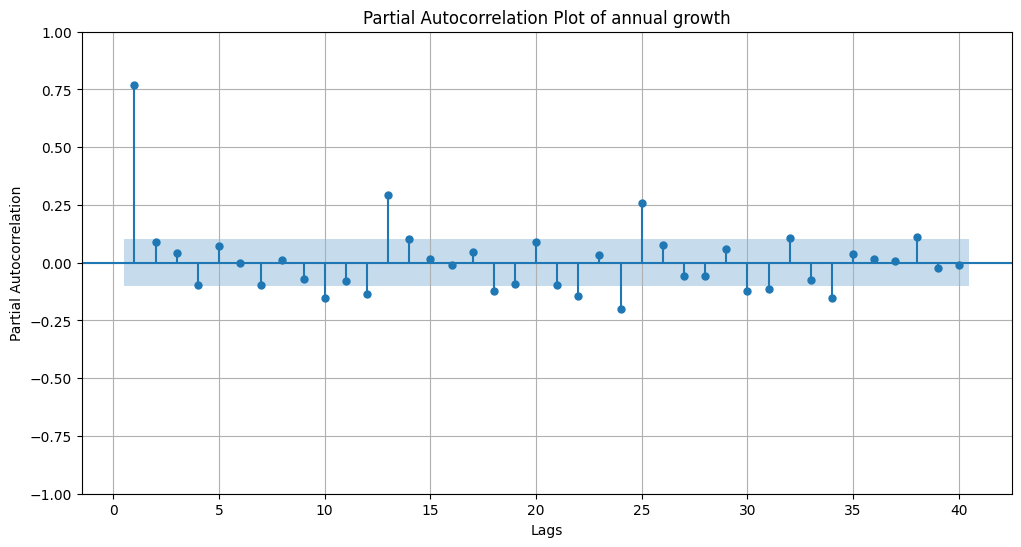

In [10]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(annual_growth['annualgrowth'], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of annual growth')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

### 1.4. Calibrating the ARIMA-SARIMA model

In [11]:
igae_log = igaedf['logIGAE'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 0), 
                seasonal_order=(0, 1, 0, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.04375D+00    |proj g|=  1.10604D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     12      1     0     0   8.274D-04  -2.044D+00
  F =  -2.0437577267561831     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                            logIGAE   No. Observations:                  392
Model:      

Luego, se guardan los coeficientes.

In [12]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)

phi0 = intercept = 0.004334
phi1 = 0.769374


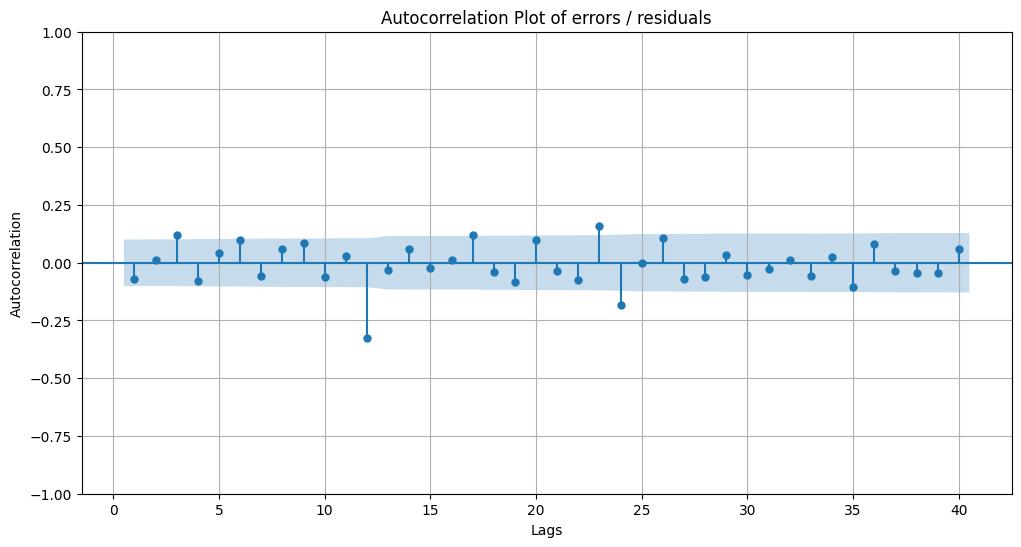

In [13]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

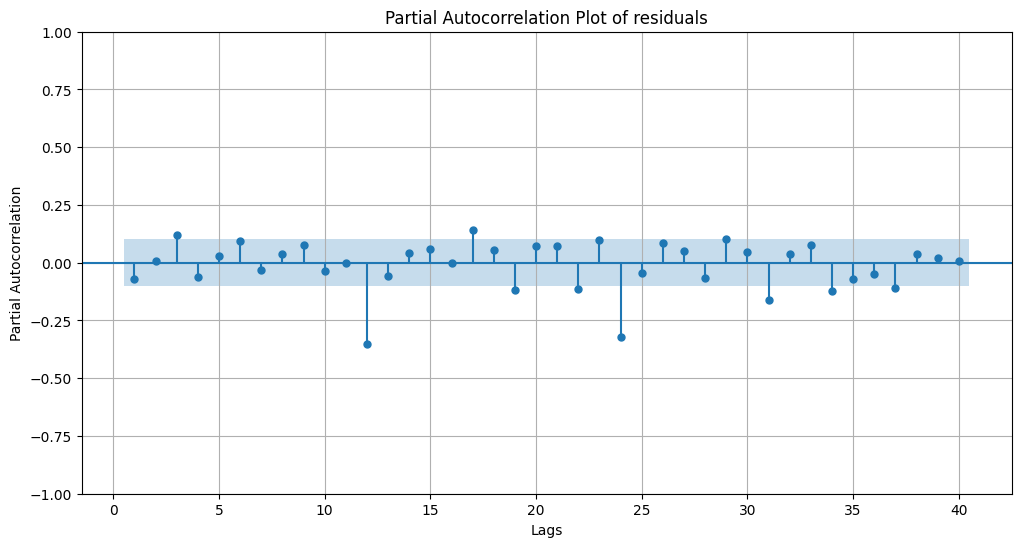

In [14]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

El siguiente modelo se hace con los valores de P = 0 y Q = 1. Esto debido a que primero se selecciona el elemento MA y se descarta el AR.

In [15]:
igae_log = igaedf['logIGAE'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 0), 
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/root/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.09620D+00    |proj g|=  3.68667D+00

At iterate    5    f= -2.10813D+00    |proj g|=  4.41193D+00

At iterate   10    f= -2.19039D+00    |proj g|=  4.85664D+00

At iterate   15    f= -2.19453D+00    |proj g|=  6.54835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during

El valor de theta1, el término de MA, tuvo valor de -0.81 con un p-value menor a 0.005, volviéndolo estadísticamente significativo. 

In [16]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.S.L12']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)
print('theta1 = %f' % theta1)

phi0 = intercept = 0.004126
phi1 = 0.779778
theta1 = -0.789194


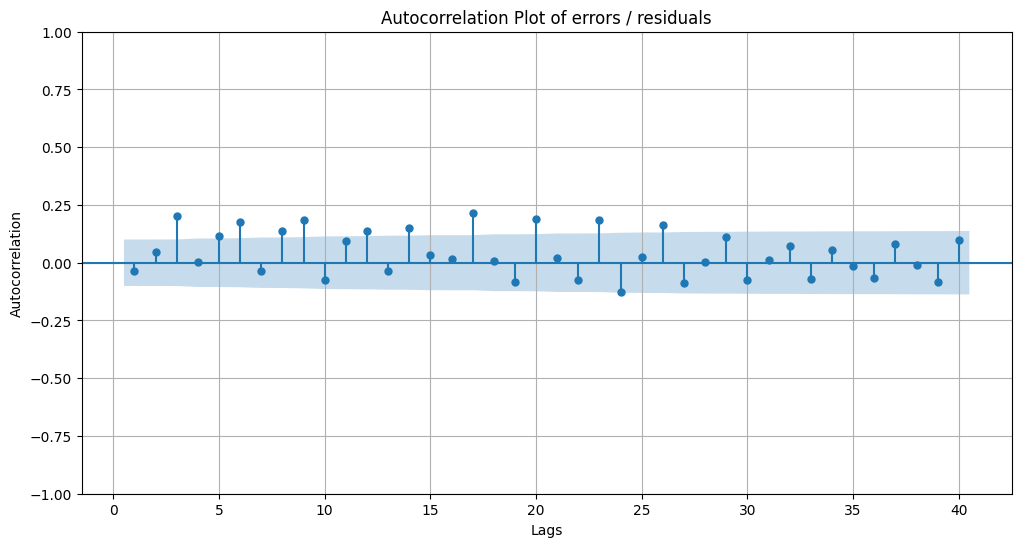

In [17]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

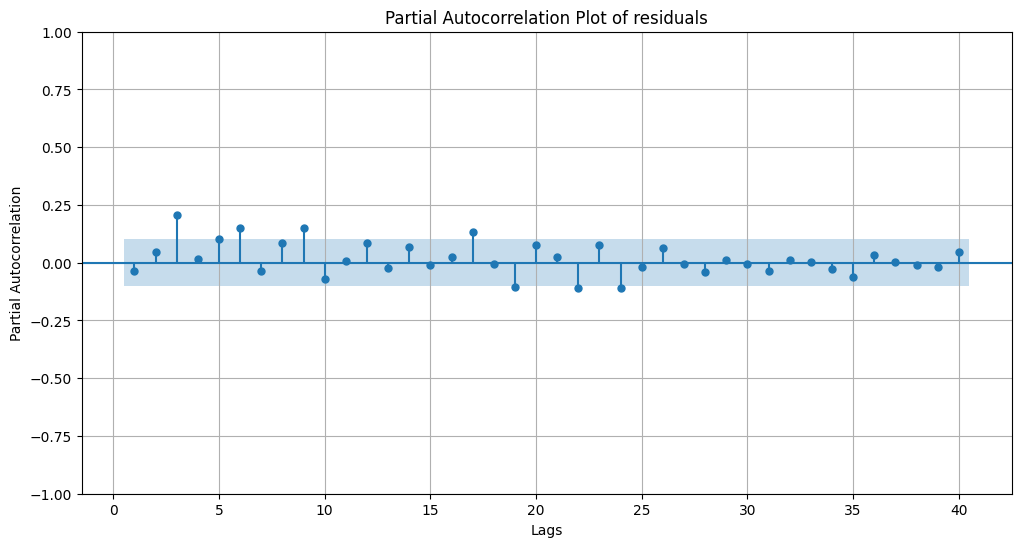

In [18]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Ahora, se cambiará el q = 1 debido a que hay una correlación significativa con el lag 1. 

In [19]:
# Fit SARIMA model ARIMA(p=1,d=0,q=1) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 1), 
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/root/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.10247D+00    |proj g|=  3.86354D+00

At iterate    5    f= -2.10641D+00    |proj g|=  5.63970D-01

At iterate   10    f= -2.12843D+00    |proj g|=  1.04296D+01

At iterate   15    f= -2.20535D+00    |proj g|=  8.52854D-01

At iterate   20    f= -2.20569D+00    |proj g|=  9.35170D-02

At iterate   25    f= -2.20837D+00    |proj g|=  5.19959D-01

At iterate   30    f= 

Debido a que todos los coeficientes son significativos, se conservan en el modelo.

In [20]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.L1']
theta2 = result.params['ma.S.L12']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)
print('theta1 = %f' % theta1)
print('theta2 = %f' % theta2)

phi0 = intercept = 0.001417
phi1 = 0.923609
theta1 = -0.256074
theta2 = -0.825872


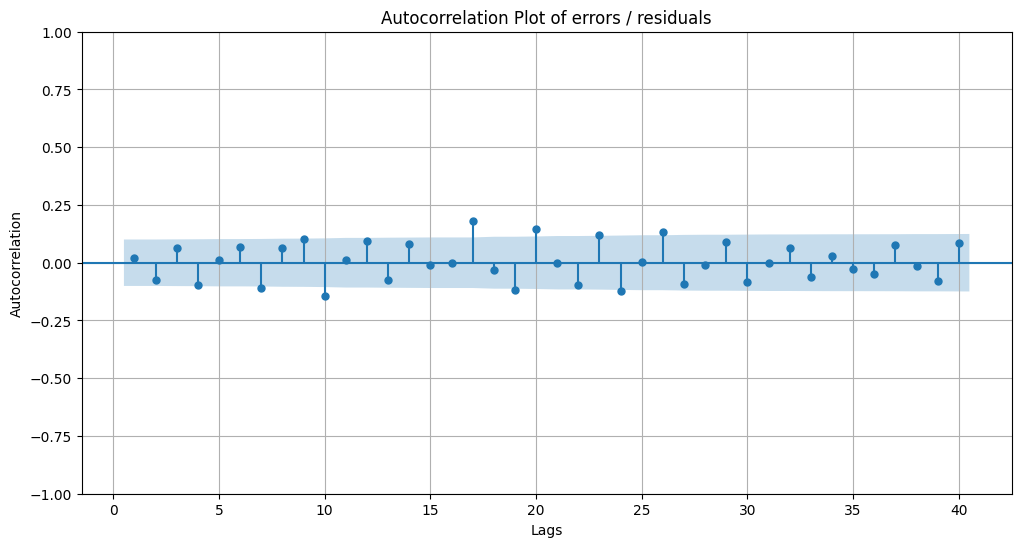

In [21]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

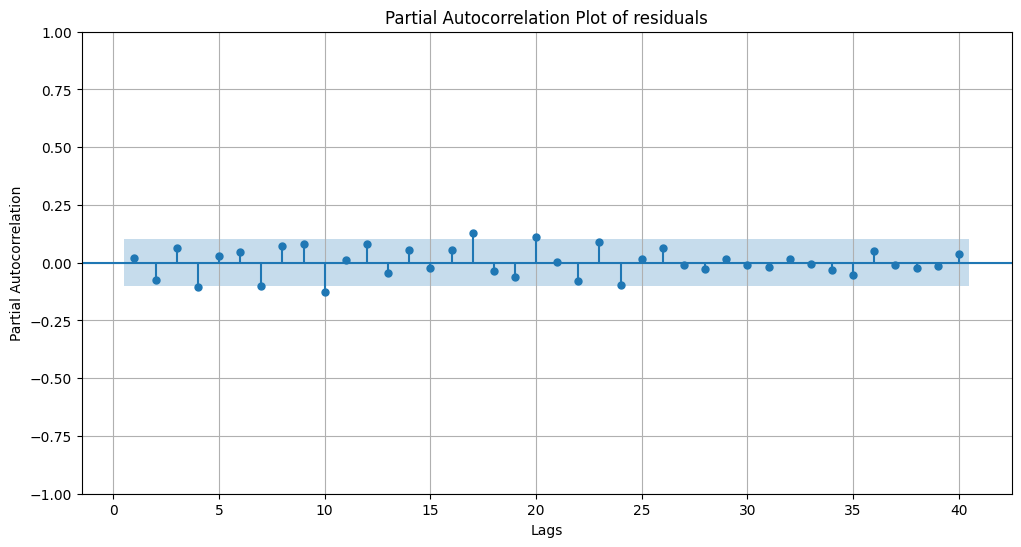

In [22]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

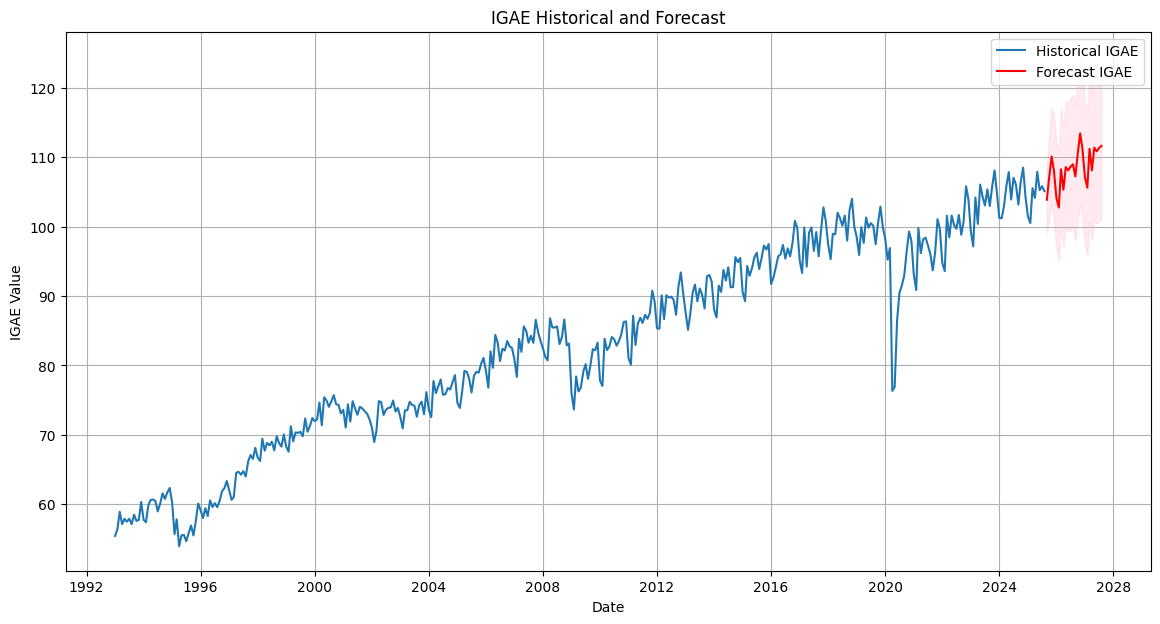

In [23]:
# I will forecast 24 months in the future:
forecast_steps = 24
forecast_result = result.get_forecast(steps=forecast_steps)
# I get the mean forecast:
forecast_log = forecast_result.predicted_mean
# Get the 95% confidence interval of the forecast: 
# alpha = 1 - confidence interval
forecast_ci = forecast_result.conf_int(alpha=0.05)

# Convert log forecast values back to original scale of IGAE
forecast_values = np.exp(forecast_log)

# Plot historical and forecast values
plt.figure(figsize=(14, 7))
plt.plot(igaedf.index, igaedf['IGAE'], label='Historical IGAE')
plt.plot(forecast_values.index, forecast_values, label='Forecast IGAE', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval

plt.title('IGAE Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)
plt.legend()
plt.show()

### 1.5 Interpretation

In [24]:
# Fit SARIMA model ARIMA(p=1,d=0,q=1) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 1), 
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/root/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.10247D+00    |proj g|=  3.86354D+00

At iterate    5    f= -2.10641D+00    |proj g|=  5.63970D-01

At iterate   10    f= -2.12843D+00    |proj g|=  1.04296D+01

At iterate   15    f= -2.20535D+00    |proj g|=  8.52854D-01

At iterate   20    f= -2.20569D+00    |proj g|=  9.35170D-02

At iterate   25    f= -2.20837D+00    |proj g|=  5.19959D-01

At iterate   30    f= 

### 1.6. Declaración de funciones 

Para facilitar el trabajo posterior, se modulariza el código en funciones

In [25]:
def dicky_fuller(df_column):
    dftest = adfuller(df_column.dropna())
    print('ADF Statistic: %f' % dftest[0])
    print('p-value: %f' % dftest[1])

    return dftest

In [26]:
def annual_ac_plot(df, column):
    df_temp = df.dropna(
        subset=[column])

    plt.figure(figsize=(12, 6))
    plot_acf(df_temp[column],
            lags=40, zero=False, ax=plt.gca())
    plt.title('AC Plot of annual growth')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()

def result_ac_plot(result):
    plt.figure(figsize=(12, 6))
    plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
    plt.title('Autocorrelation Plot of errors / residuals')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()

In [27]:
def annual_pac_plot(df, column):
    df_temp = df.dropna(
        subset=[column])

    plt.figure(figsize=(12, 6))
    plot_pacf(df_temp[column], zero=False, lags=40,
                ax=plt.gca())
    plt.title('PAC Plot of annual growth')
    plt.xlabel('Lags')
    plt.ylabel('Partial Autocorrelation')
    plt.grid(True)
    plt.show()

def result_pac_plot(result):
    plt.figure(figsize=(12, 6))
    plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
    plt.title('Partial Autocorrelation Plot of residuals')
    plt.xlabel('Lags')
    plt.ylabel('Partial Autocorrelation')
    plt.grid(True)
    plt.show()

## 2. Challenge 1

El objetivo es realizar un modelo ARIMA-SARIMA para predecir el resto de 2025 y el año 2026 del Producto Interno Burto en México. Para esto, se debe primeramente encontrar un formato de la serie de tiempo en que esta sea *stationary*. Posteriormente, se calibra el modelo hasta que este explique todos los LAGS en el tiempo. 

### 2.1 Encontrando estacionariedad

In [28]:
pip install pandas_datareader --quiet


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [30]:
# prompt: Download the series NGDPRNSAXDCMXQ from the FRED site since 1993, and using pandas_reader
# Install the pandas_datareader:
# This part is already done in the preceding code.
series_id = "NGDPRNSAXDCMXQ"
mxgdpdf = pdr.get_data_fred(series_id,start='1993-01-01')
mxgdpdf.columns=['MXGDP']
print(mxgdpdf.head())

                MXGDP
DATE                 
1993-01-01  3439763.5
1993-04-01  3472286.3
1993-07-01  3465719.7
1993-10-01  3519338.2
1994-01-01  3525020.1


Se observa que el comportamiento no es estacionario. Igual que en el ejemplo abordado anteriormente, se observa la caída de 2020 debido a la pandemia. Para encontrar una versión de los datos estacionaria, primeramente se hará una trnasformación a logaritmos.

Como se esperaba, la transformación a logaritmos no aseguró que se volviera estacionaria. Se observa la misma tendencia de los datos pero ahora con un rango porcentual. 
Ahora, se analizará el cambio porcentual anual.

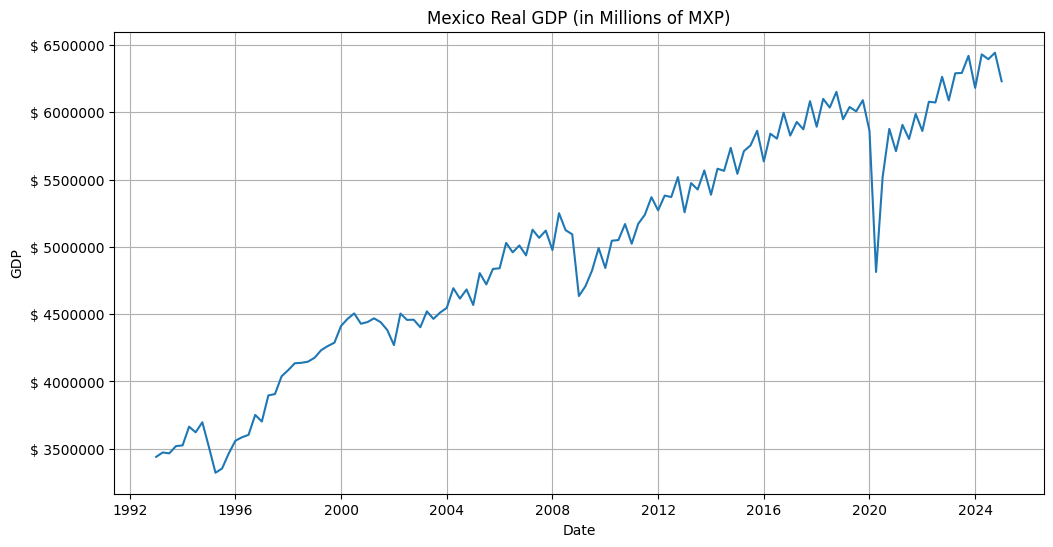

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'])
plt.title('Mexico Real GDP (in Millions of MXP)')
plt.xlabel('Date')
plt.ylabel('GDP')
# Format the y-axis to show in currency format
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True)
plt.show()

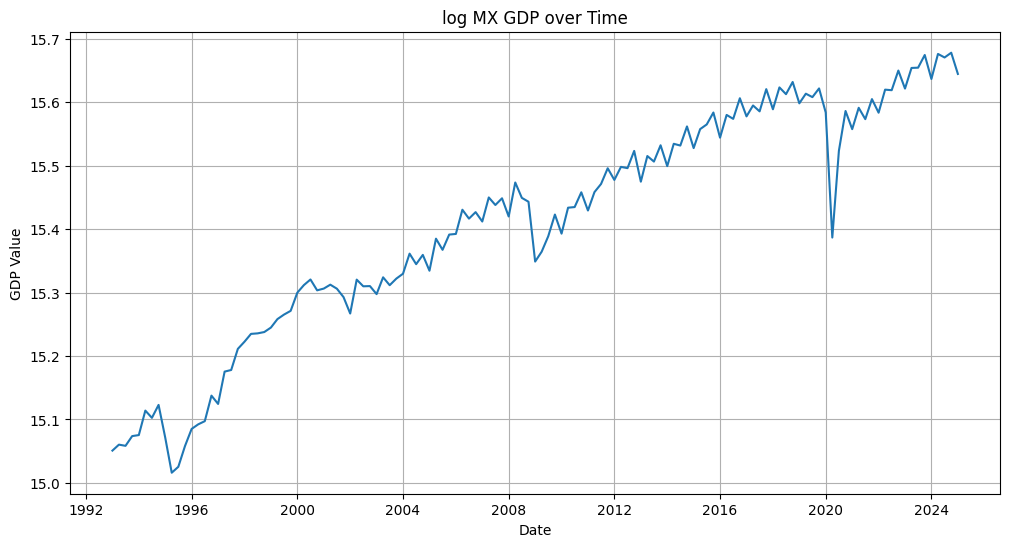

In [32]:
mxgdpdf['logMXGDP'] = np.log(mxgdpdf['MXGDP'])

plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, mxgdpdf['logMXGDP'])
plt.title('log MX GDP over Time')
plt.xlabel('Date')
plt.ylabel('GDP Value')
plt.grid(True)
plt.show()

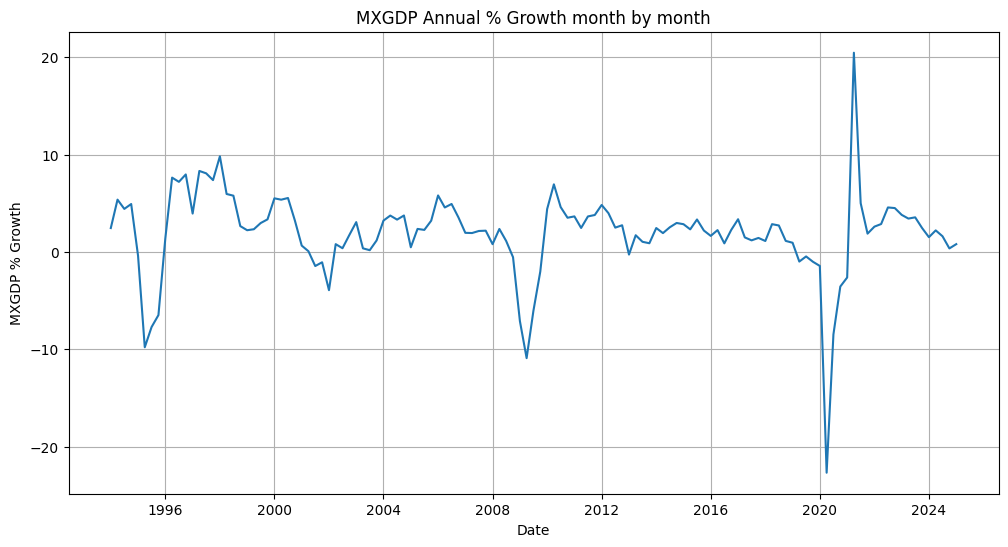

In [33]:
mxgdpdf['annualgrowth'] = mxgdpdf['logMXGDP'] - mxgdpdf['logMXGDP'].shift(4)

plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, 100 * mxgdpdf['annualgrowth'])
plt.title('MXGDP Annual % Growth month by month')
plt.xlabel('Date')
plt.ylabel('MXGDP % Growth')
plt.grid(True)
plt.show()

La gráfica muestra el *annual percentual change* de la serie de tiempo. Se visualiza la caída de 2020 y la recuperación alta de 2021. A simple vista, parece una serie *stationary*. Sin eembargo, debido a que nuestro ojo no es capaz de pericibirlo con exactitud, se realiza un test de Dickey-Fuller.

* **H0**: La serie no es estacionaria.
* **H1**: La serie es estacionaria.

El test obtuvo un *p-value* = 0.007. Al ser menor que 0.05, se rechaza la hipótesis nula y se concluye que la serie es estacionaria.

Con una versión estacionaria de la serie, se puede continuar con la generación del modelo.


In [34]:
dftest_1 = dicky_fuller(mxgdpdf['annualgrowth'])

ADF Statistic: -3.527930
p-value: 0.007298


Los valores que sobrepasan el área azul son aquellos con una autocorrelación estadísticamente significativa.
* **Autocorrelation:** La gráfica muestra que los valores *t-1* y *t-2* son significativos y positivos en cualquier punto del tiempo, con una autocorrelación mayor a 0.5 y 0.25, relativamente. 
* **Partial Autocorrelation:** La gráfica muestra significancia estadística en los valores *t-1*, *t-4* y *t-5*, con autocorrelaciones positivas. 

Observando el PAC, vemos que realmente la única que tenía el efecto significativo era LAG 1, pues es la que explica la mayor parte de la relación.

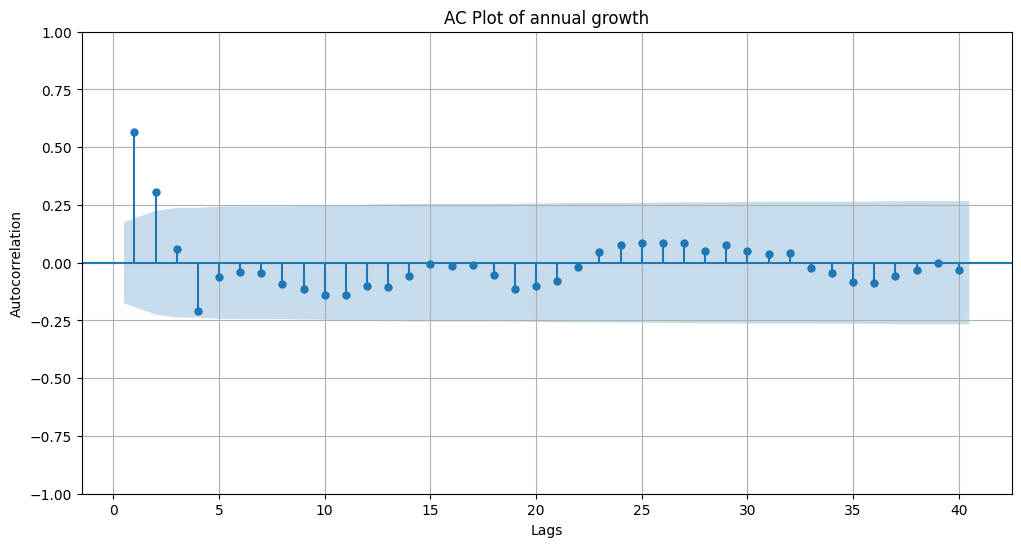

In [35]:
# Drop NaN values created by the differencing
annual_ac_plot(mxgdpdf, 'annualgrowth')

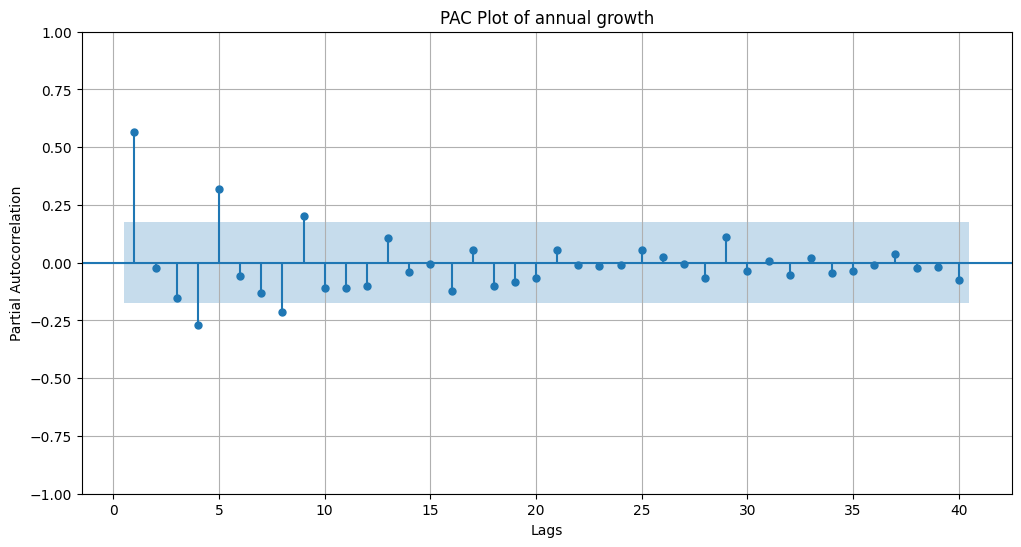

In [36]:
annual_pac_plot(mxgdpdf, 'annualgrowth')


### 2.2 Calibrando modelo

Se deben encontrar los valores necesarios de p, d, q, P, D and Q para realizar el modelo. El objetivo es realizar modelos y calibrarlos hasta que todo sea explicable con el modelo hecho. Es decir, hasta que todos los valores de Yt-k se encuentren dentro del intervalo de 95% de confianza y el modelo sea capaz de explicarlos.

Debido a que se encontró que el porcentaje de cambio anual es estacionario, los valores de d y D se toman como *d = 0* y *D = 1*. En otras palabras, no se aplica una diferencia en la medida de la granularidad de la serie (trimestres), pero sí se aplica en la season, es decir, un año. 

Se observa una autocorrelación parcial positiva con el LAG 1, por lo que el número de p = 1. Al buscar evaluar actualmente sólo el patrón AR, q se mantiene como 0. La razón por la que no se toman en cuenta las otras PAC significativas es que no están seguidas. 

In [37]:
logMXGDP = mxgdpdf['logMXGDP'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)
model_1 = SARIMAX(logMXGDP, order=(1, 0, 0), 
                seasonal_order=(0, 1, 0, 4),
                trend='c') # Include drift/constant term
result_1 = model_1.fit()
print(result_1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.84361D+00    |proj g|=  2.18409D-01

At iterate    5    f= -1.84362D+00    |proj g|=  1.57955D-02

At iterate   10    f= -1.84364D+00    |proj g|=  5.18533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     27      1     0     0   5.181D-04  -1.844D+00
  F =  -1.8436367484511178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                  

Los coeficientes obtenidos fueron *phi0 = 0.008* y *phi1 = 0.563*, ambos estadísticamente significativos. Phi1 indica que el valor de Yt-1 tiene más de la mitad de influencia en el valor de Yt. Phi0 indica que el valor de Yt es 0.008 unidades mayor que el valor de Yt-1.

In [38]:
phi0_1 = result_1.params['intercept']
phi1_1 = result_1.params['ar.L1']
print('phi0 = intercept = %f' % phi0_1)
print('phi1 = %f' % phi1_1)

phi0 = intercept = 0.008441
phi1 = 0.563585


En ambas gráficas, se observa significancia estadística en el LAG 4, que justamente concuerda con la *season* debido a que el año tiene 4 trimestres y las gráficas se presentan el formato granular de los datos, NO anual. 

Debido a que ambas autocorrelaciones son negativas, se comenzará probando con los valores de P = 0 y Q = 1. Esto debido a que, por simple regla común, primero se selecciona el elemento MA y se descarta el AR.

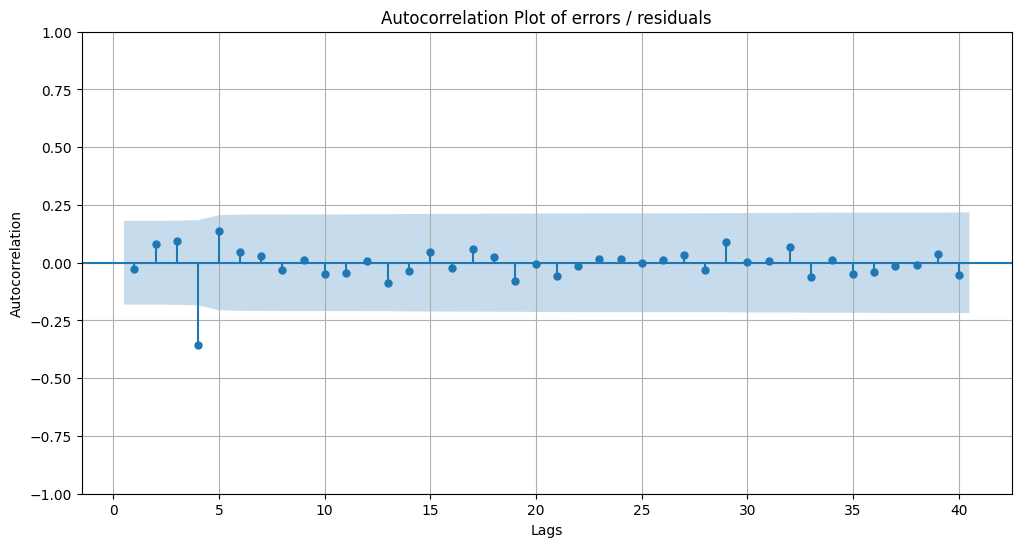

In [39]:
result_ac_plot(result_1)

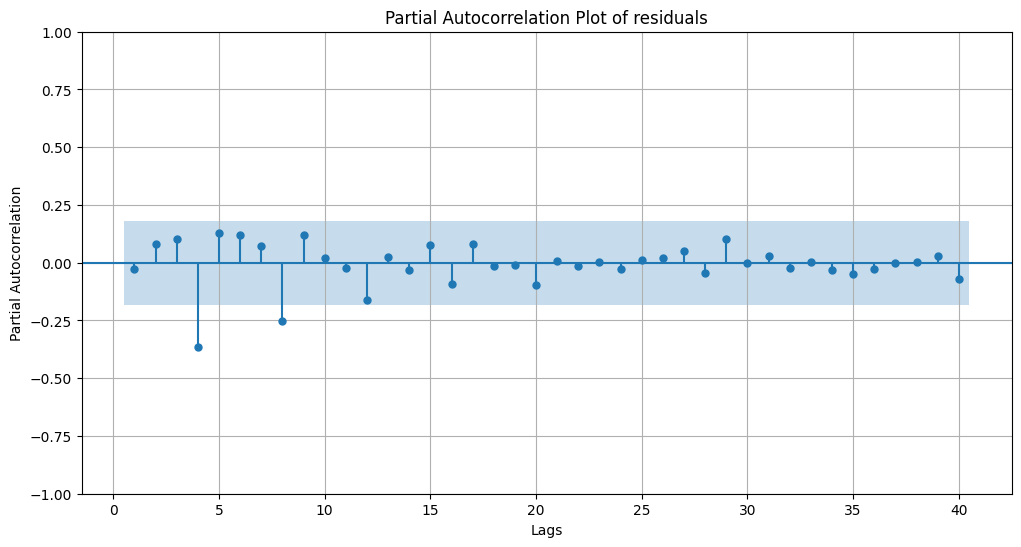

In [40]:
result_pac_plot(result_1)

In [41]:
# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=1,#periods=4)
model_2 = SARIMAX(logMXGDP, order=(1, 0, 0), 
                seasonal_order=(0, 1, 1, 4),
                trend='c') # Include constant
result_2 = model_2.fit()
print(result_2.summary())

/root/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87732D+00    |proj g|=  2.08477D+00

At iterate    5    f= -1.88286D+00    |proj g|=  3.00853D+00

At iterate   10    f= -1.99024D+00    |proj g|=  8.02982D+00

At iterate   15    f= -2.00062D+00    |proj g|=  1.80919D-01

At iterate   20    f= -2.03225D+00    |proj g|=  4.31562D+00

At iterate   25    f= -2.03535D+00    |proj g|=  1.12493D-01

           * *

Los coeficientes obtenidos fueron *phi0 = 0.003*, *phi1 = 0.792* y *theta1 = -0.835*, todos siendo estadísticamente significativos.

Phi1 indica que el valor de Yt-1 tiene aprox. el 79% . Phi0 indica que el valor de Yt es 0.003 unidades mayor que el valor de Yt-1. Theta1 indica que cada season/año, es decir, Yt-4 tiene una influencia negativa de -0.835.

In [42]:
phi0_2 = result_2.params['intercept']
phi1_2 = result_2.params['ar.L1']
theta1_2 = result_2.params['ma.S.L4']
print('phi0 = intercept = %f' % phi0_2)
print('phi1 = %f' % phi1_2)
print('theta1 = %f' % theta1_2)

phi0 = intercept = 0.003906
phi1 = 0.792347
theta1 = -0.835242


Como se observa en ambas gráficas, ya todos los LAGS se encuentran dentro del intervalo de confianza. Esto quiere decir que el modelo ya es el adecuado para el conjunto de datos y puede realizarse la predicción final.

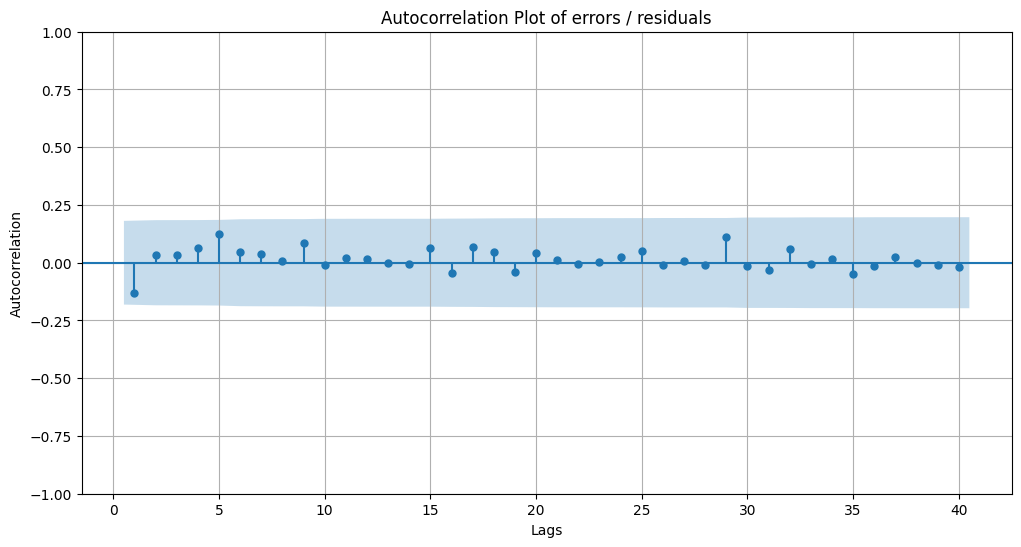

In [43]:
result_ac_plot(result_2)

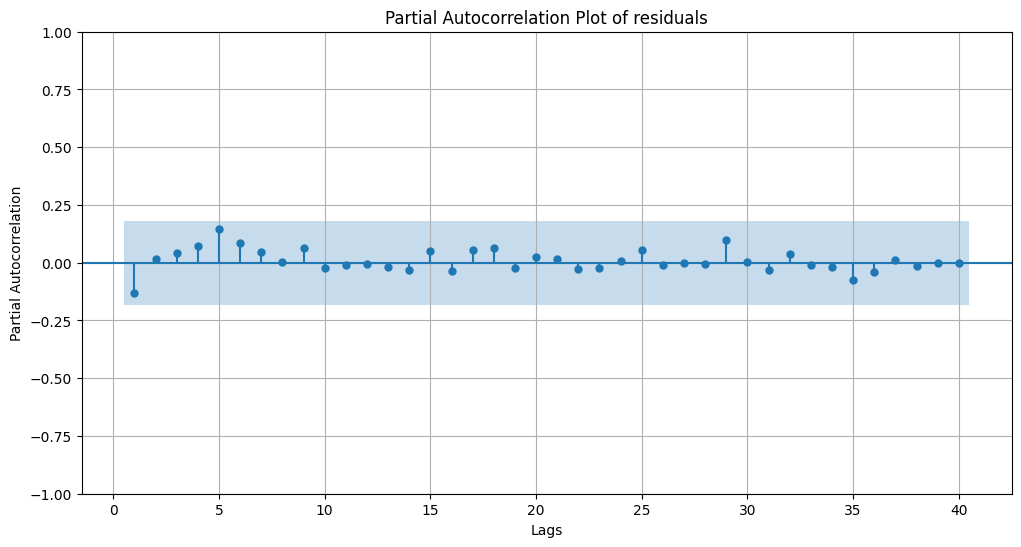

In [44]:
result_pac_plot(result_2)

### 2.3. Interpretación del modelo

El modelo ARIMA-SARIMA se realizó con el logaritmo del GDP (Producto Interno Bruto, PIB) y modela el cambio porcentual anual, pues su *D = 1* y su *d = 0*. 

* AR(p = 1): Esta parte del modelo regresó un *phi1 = 0.79*. Al ser estadísticamente significativo, significa que el cambio porcentual anual del GDP se autocorrelaciona positivamente con su propio cambio porcentual del trimestre pasado. O, en otras palabras, se utiliza el 79% del trimestre anterior para predecir el trimestre actual. 

* MA(Q = 1): El modelo dio un *theta1 = -0.835* estadísticamente significativo. El cambio porcentual aual del GDP se autocorrelaciona negativamente con su propio cambio porcentual de un año atrás. Esto implica que si uno sube, el otro aumenta y viceversa. El cambio porcentual de un año anterior se multiplica por -0.835 para predecir el año actual. Viéndolo desde la perspectiva de la granularida de los datos, el cambio porcentual de cuatro periodos antes se multiplica por -0.835 para obtener el periodo actual.

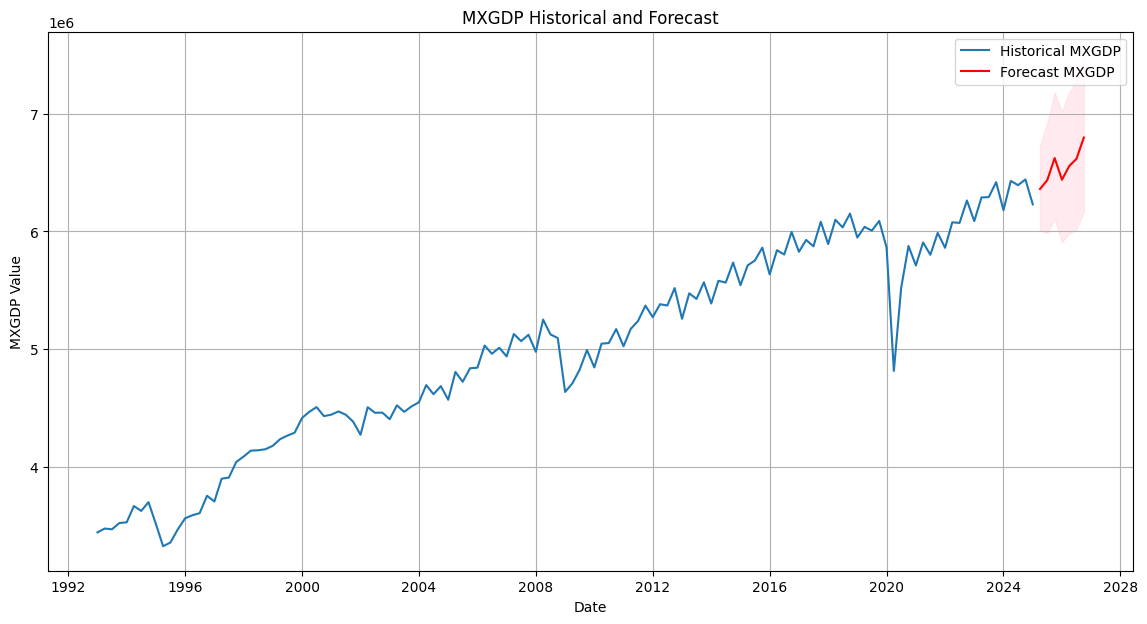

In [45]:
forecast_steps = 7
forecast_result = result_2.get_forecast(steps=forecast_steps)
forecast_log = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)

forecast_values = np.exp(forecast_log)

plt.figure(figsize=(14, 7))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'], label='Historical MXGDP')
plt.plot(forecast_values.index, forecast_values, label='Forecast MXGDP', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval

plt.title('MXGDP Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('MXGDP Value')
plt.grid(True)
plt.legend()
plt.show()

## 3. Challenge 2

El objetivo es realizar un modelo ARIMA-SARIMA para predecir el GDP de Estados Unidos para el resto de 2025 y todo el año 2026. Después de encontrar una serie *stationary* y calibrar el modelo, se busca intergrarlo con el modelo de México para agregar a Estados Unidos como una variable explicativa. Es decir, se busca observar el efecto que tiene el GDP de Estados Unidos en el de México. 

### 3.1 Encontrando estacionariedad

In [46]:
series_id = "GDPC1"
usgdpdf = pdr.get_data_fred(series_id,start='1993-01-01')
usgdpdf.columns=['USGDP']
print(usgdpdf.head())

                USGDP
DATE                 
1993-01-01  10576.275
1993-04-01  10637.847
1993-07-01  10688.606
1993-10-01  10833.987
1994-01-01  10939.116


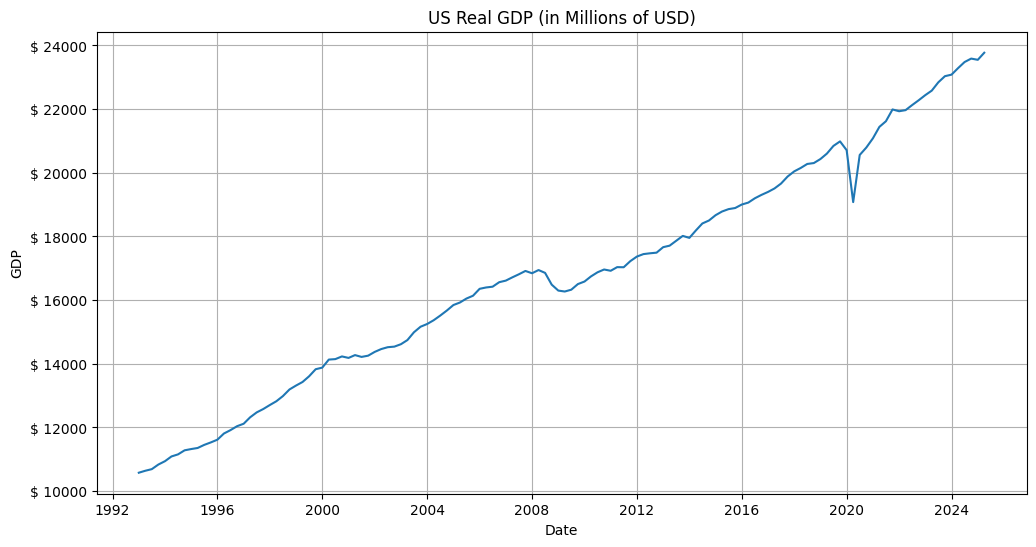

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, usgdpdf['USGDP'])
plt.title('US Real GDP (in Millions of USD)')
plt.xlabel('Date')
plt.ylabel('GDP')
# Format the y-axis to show in currency format
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True)
plt.show()

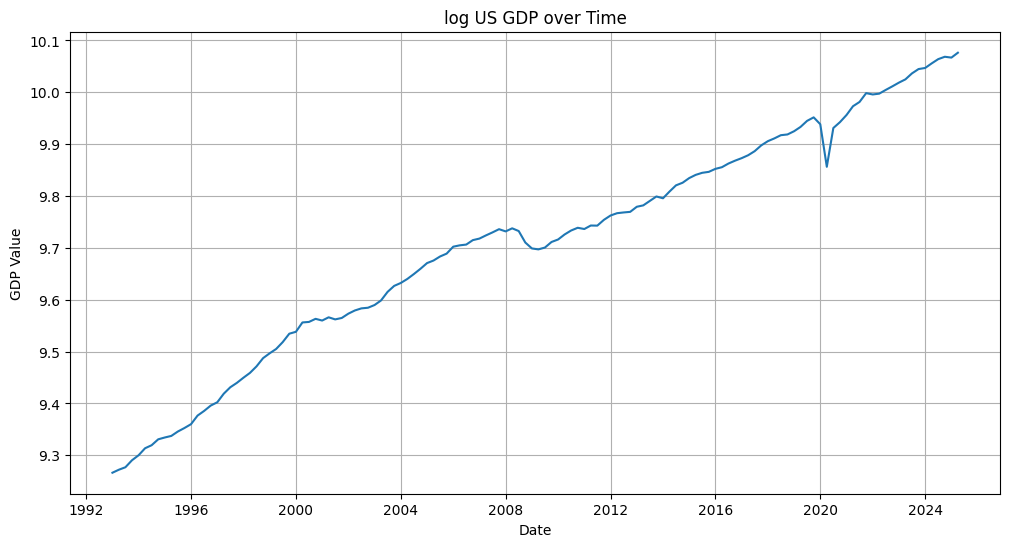

In [48]:
usgdpdf['logUSGDP'] = np.log(usgdpdf['USGDP'])

plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, usgdpdf['logUSGDP'])
plt.title('log US GDP over Time')
plt.xlabel('Date')
plt.ylabel('GDP Value')
plt.grid(True)
plt.show()

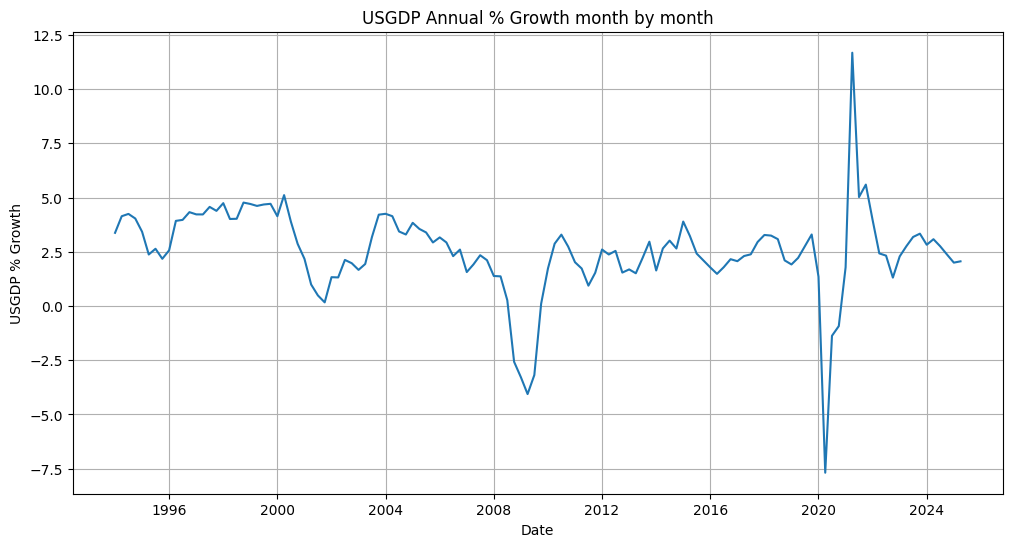

In [49]:
usgdpdf['annualgrowth'] = usgdpdf['logUSGDP'] - usgdpdf['logUSGDP'].shift(4)

plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, 100 * usgdpdf['annualgrowth'])
plt.title('USGDP Annual % Growth month by month')
plt.xlabel('Date')
plt.ylabel('USGDP % Growth')
plt.grid(True)
plt.show()

El ADF Statistic no es estadísticamente significativo, teniendo un *p-value = 0.099*, por lo que no se rechaza la hipótesis nula y no puede utilizarse para realizar el modelo ARIMA-SARIMA.

Debido a que no es *stationary*, se decide aplicar la primera diferencia entre periodos (trimestres), es decir, asignar un valor de *d = 1*.  

Para probarlo, se realiza una prueba haciendo que los datos se comporten de esta manera.

In [50]:
dftest_3 = dicky_fuller(usgdpdf['annualgrowth'])

ADF Statistic: -2.568448
p-value: 0.099695


Se observa que ahora el *p-value* es bastante significativo. Esto quiere decir que, en efecto, el tipo de modelo se vuelve *stationary* al aplicar la primera diferencia entre trimestres. 

In [51]:
# Primera diferencia del crecimiento anual
usgdpdf['trimester_annualgrowth'] = usgdpdf['logUSGDP'] - usgdpdf['logUSGDP'].shift(1)

dftest_4 = dicky_fuller(usgdpdf['trimester_annualgrowth'])

ADF Statistic: -13.103152
p-value: 0.000000


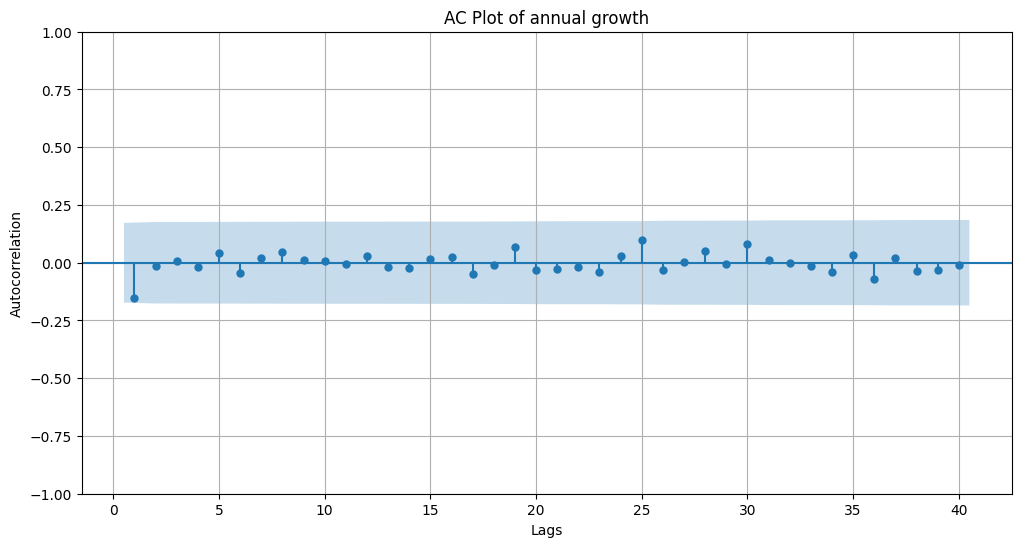

In [52]:
annual_ac_plot(usgdpdf, 'trimester_annualgrowth')

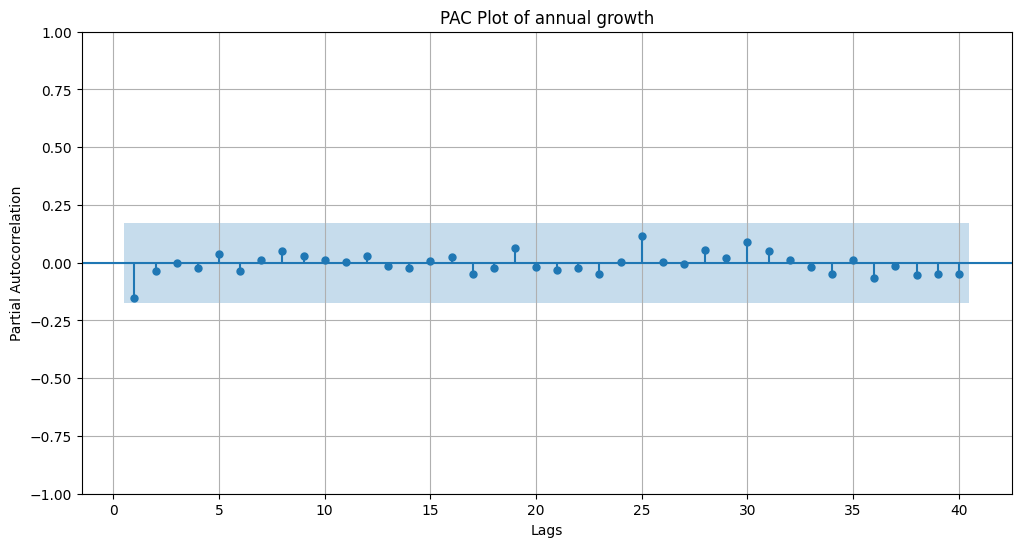

In [53]:
annual_pac_plot(usgdpdf, 'trimester_annualgrowth')

### 3.2. Calibrando modelo

In [54]:
logUSGDP = usgdpdf['logUSGDP'].dropna()

# Fit SARIMA model ARIMA(p=1,d=1,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)
model_3 = SARIMAX(logUSGDP, order=(1, 1, 0), 
                seasonal_order=(0, 0, 0, 4),
                trend='c') # Include drift/constant term
result_3 = model_3.fit()
print(result_3.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.03909D+00    |proj g|=  7.51847D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     13      1     0     0   6.674D-02  -3.039D+00
  F =  -3.0391047941697917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:               logUSGDP   No. Observations:                  130
Model:               SARIMAX(1, 1, 0

In [55]:
phi0_3 = result_3.params['intercept']
phi1_3 = result_3.params['ar.L1']
print('phi0 = intercept = %f' % phi0_3)
print('phi1 = %f' % phi1_3)

phi0 = intercept = 0.007240
phi1 = -0.153776


Ambas gráficas muestran que ya todos los LAGS se encuentran en el 95% del intervalo de confianza. Esto quiere decir que ahora ya se toman en cuenta todos los parámetros necesarios para que el modelo de predicción de Estados Unidos funciona con el comportamiento de los datos.

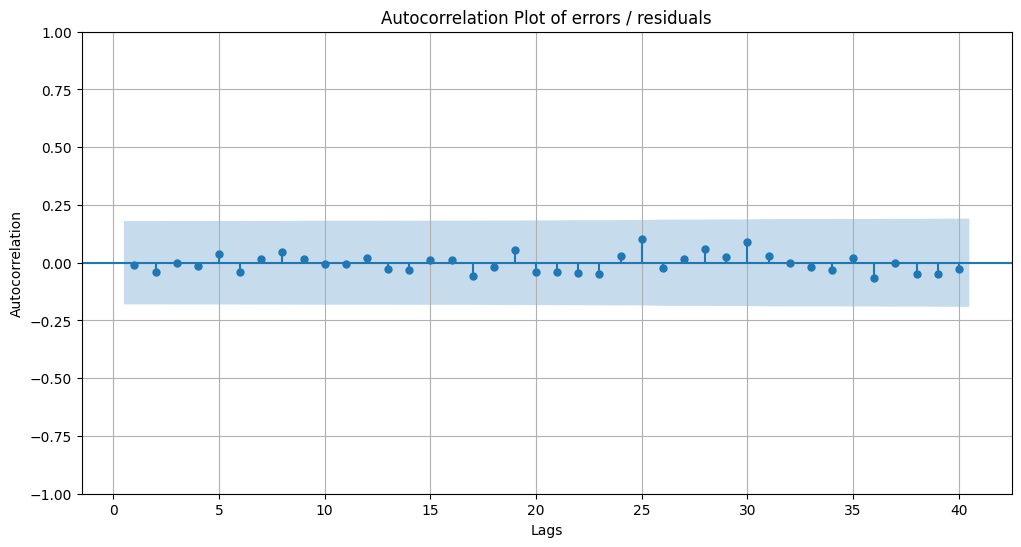

In [56]:
result_ac_plot(result_3)

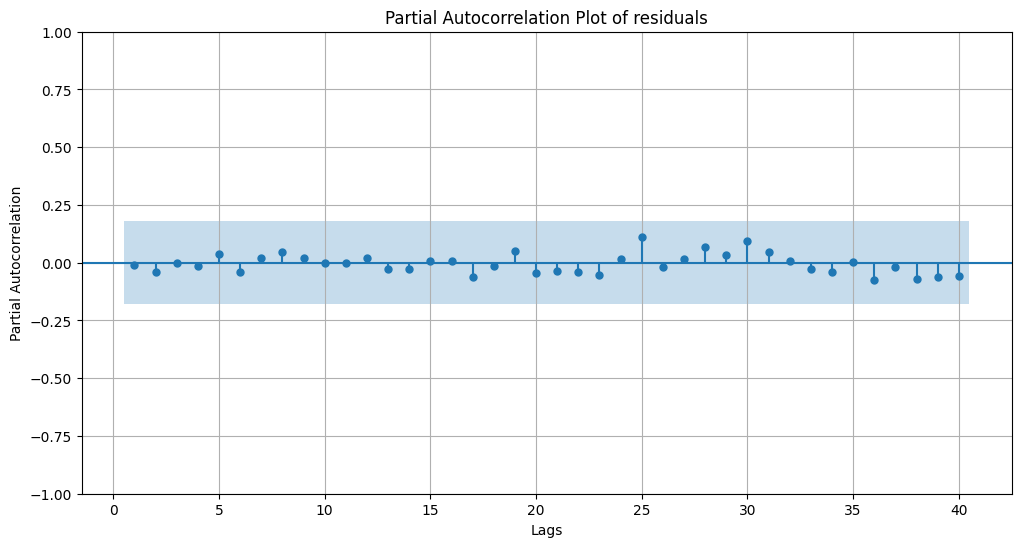

In [57]:
result_pac_plot(result_3)

### 3.3. Usando variable exógena

Ahora, se busca agregar el modelo ARIMA-SARIMA de Estados Unidos como variable exógena al modelo de México, convirtiéndolo en un modelo SARIMAX. El modelo de México es el que se toma como base con sus parámetros finales elegidos. La única diferencia es que se específica que el logaritmo de los valores de Estados Unidos es ahora la variable exógena.

In [58]:
logUSGDP = logUSGDP.iloc[:-1]

model_exog = SARIMAX(logMXGDP, order=(1, 0, 0), 
                seasonal_order=(0, 1, 1, 4),
                trend='c',
                exog = logUSGDP)
result_exog = model_exog.fit()
print(result_exog.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.27159D+00    |proj g|=  4.50794D+00

At iterate    5    f= -2.27727D+00    |proj g|=  3.30407D+00

At iterate   10    f= -2.36794D+00    |proj g|=  1.60526D+01

At iterate   15    f= -2.41089D+00    |proj g|=  3.01679D-01

At iterate   20    f= -2.41754D+00    |proj g|=  6.20764D+00

At iterate   25    f= -2.46516D+00    |proj g|=  2.18656D+00

At iterate   30    f= -2.46652D+00    |proj g|=  2.93502D-02

At iterate   35    f= -2.46705D+00    |proj g|=  6.87268D-01

At iterate   40    f= -2.47160D+00    |proj g|=  5.11326D-01

At iterate   45    f= -2.47173D+00    |proj g|=  1.41356D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

En ambas gráficas, se observa que el primer LAG se sale del intervalo de confianza con un valor negativo. Cuando esto sucede, se asigna el valor de *q* al número de LAGS significativamente negativos. Por esta razón, al modelo base de México con la exógena de Estados Unidos le agregaremos un *q = 1*. Esto significa que consideraremos el error de un LAG Yt-1, es decir, del trimestre pasado. 

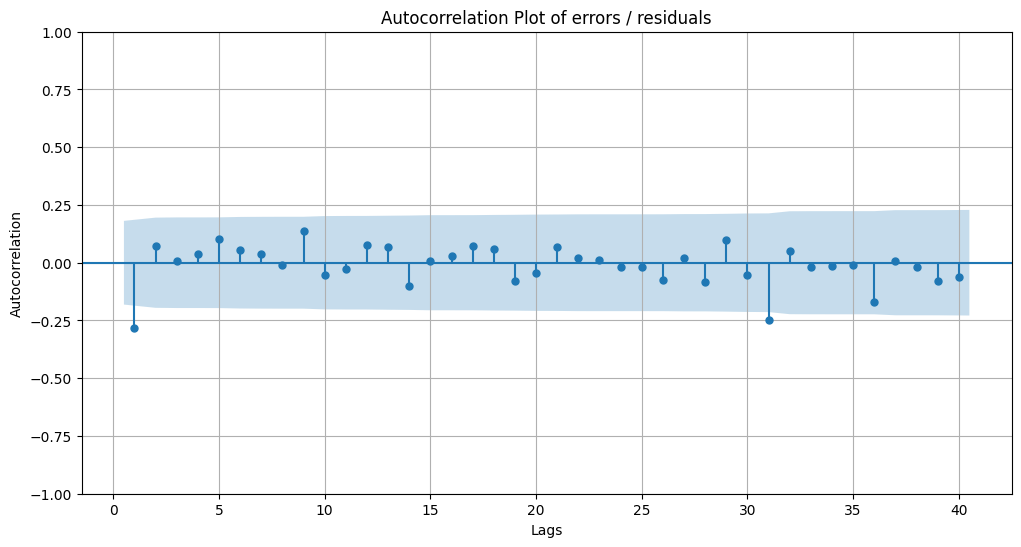

In [59]:
result_ac_plot(result_exog)

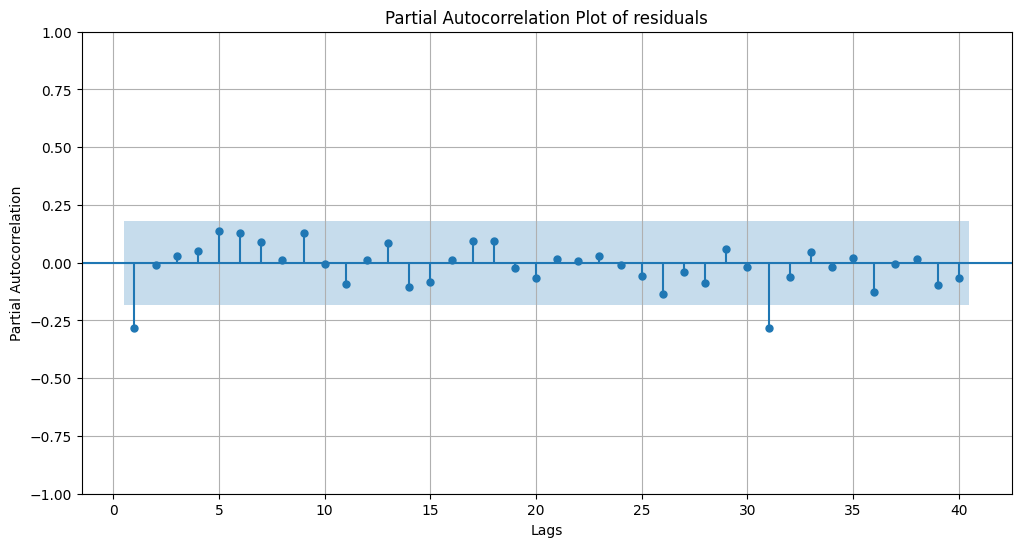

In [60]:
result_pac_plot(result_exog)

In [61]:
# Fit SARIMA model ARIMA(p=1,d=0,q=1) SARIMA(P=0,D=1,Q=1,#periods=4)
model_exog_2 = SARIMAX(logMXGDP, order=(1, 0, 1), 
                seasonal_order=(0, 1, 1, 4),
                trend='c',
                exog = logUSGDP)
result_exog_2 = model_exog_2.fit()
print(result_exog_2.summary())

/root/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.27017D+00    |proj g|=  5.06252D+00

At iterate    5    f= -2.27634D+00    |proj g|=  2.83761D+00

At iterate   10    f= -2.39229D+00    |proj g|=  1.41224D+01

At iterate   15    f= -2.41168D+00    |proj g|=  2.67559D-01

At iterate   20    f= -2.42304D+00    |proj g|=  4.56829D+00

At iterate   25    f= -2.43333D+00    |proj g|=  1.28512D-01

At iterate   3

Agregando un error del LAG pasado, es decir, agregando un valor de *q = 1*, se observa que ahora todos los LAGS se encuentran en el intervalo de confianza. Si bien el LAG 31 sobresale por poco, no se toma en cuenta debido a que, pensandolo bien, no hace sentido una relación tan lejana si las anteriores no son altas. No hace sentido ni con los trimestres ni los años. 

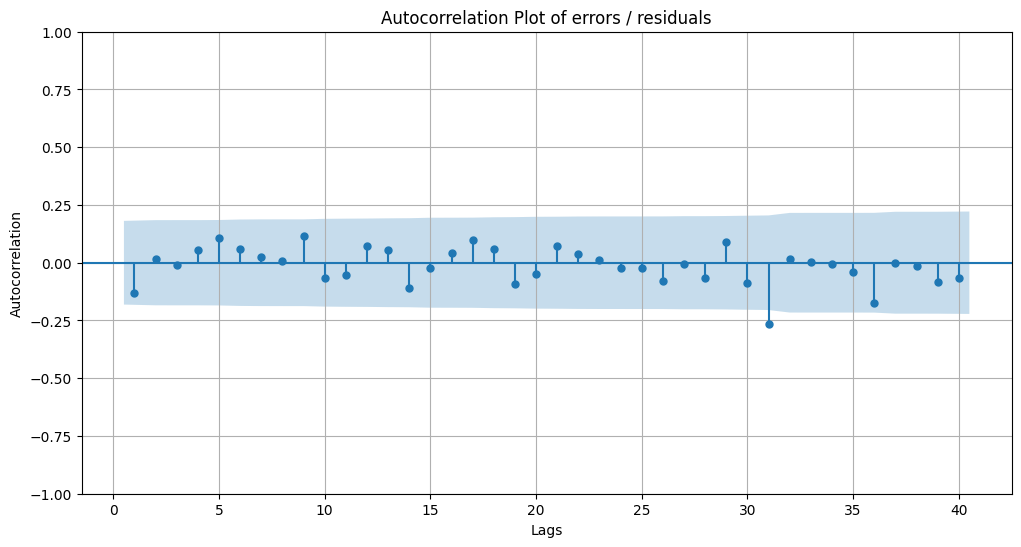

In [62]:
result_ac_plot(result_exog_2)

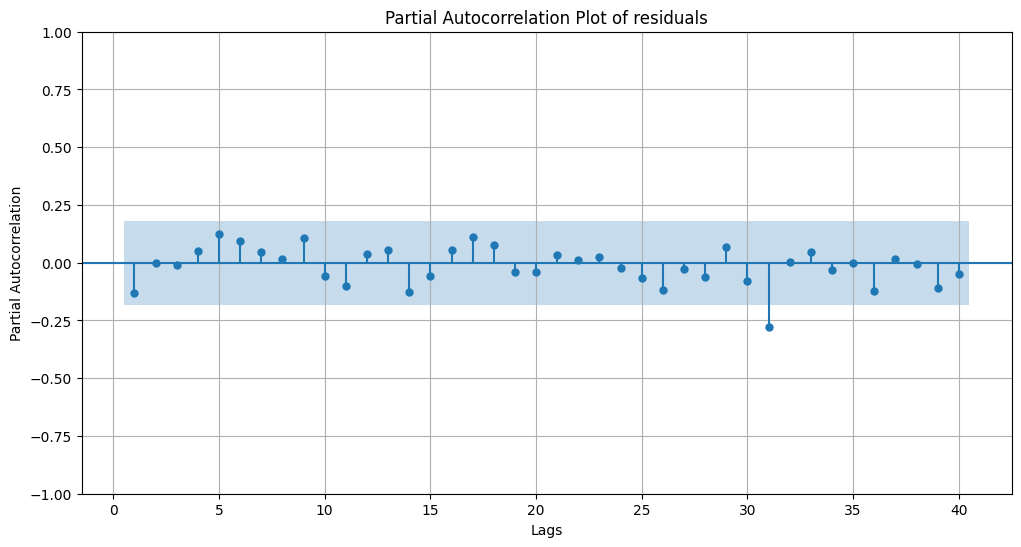

In [63]:
result_pac_plot(result_exog_2)

### 3.4. Interpretación del modelo

El modelo SARIMAX se realizó con el logaritmo del GDP (Producto Interno Bruto, PIB) de México y el GDP de Estados Unidos como variable exógena. Se quiere tomar en cuenta el efecto que tiene Estados Unidos en México al ser nuestro país vecino y principal comerciante. Este modelo maneja el cambio porcentual anual, pues su *D = 1* y su *d = 0*. Todos los coeficientes presentados a continuación son estadísticamente significativos.

* AR(p = 1): Esta parte del modelo regresó un *phi1 = 0.912*. Significa que el cambio porcentual anual del GDP se autocorrelaciona positivamente con su propio cambio porcentual del trimestre pasado. O, en otras palabras, se utiliza casi completamente el trimestre anterior para predecir el trimestre actual.

* MA(q = 1): El modelo dio un *theta1 = -0.211*. Este valor se agregó al modelo base cuando se contempló la exógena de Estados Unidos. Significa que el error del LAG (trimestre) pasado es importante para conocer el valor del tiempo actual Yt. Si uno aumenta, el otro disminuye y viceversa, aunque es una influencia baja del -0.211. Esto puede deberse debido a que los impactos negativos que tiene Estados Unidos nos afectan directamente. Si a ellos les va mal, también sufrimos shocks considerables.

* MA(Q = 1): El modelo dio un *theta2 = -0.7*. El cambio porcentual aual del GDP se autocorrelaciona negativamente con su propio cambio porcentual de un año atrás. Esto implica que si uno sube, el otro aumenta y viceversa. El cambio porcentual de un año anterior se multiplica por -0. para predecir el año actual. Viéndolo desde la perspectiva de la granularida de los datos, el cambio porcentual de cuatro periodos antes se multiplica por -0. para obtener el periodo actual.

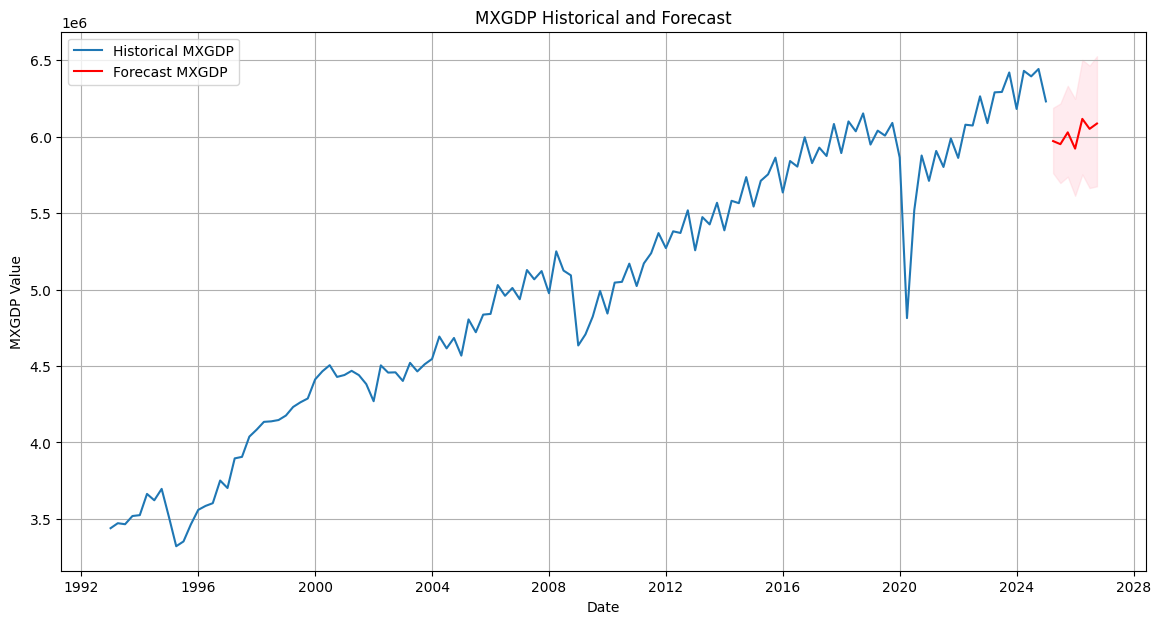

In [64]:
forecast_steps = 7
future_logUSGDP = logUSGDP.tail(7)
forecast_result = result_exog_2.get_forecast(steps=forecast_steps, exog=future_logUSGDP)
forecast_log = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)

forecast_values = np.exp(forecast_log)

plt.figure(figsize=(14, 7))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'], label='Historical MXGDP')
plt.plot(forecast_values.index, forecast_values, label='Forecast MXGDP', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval

plt.title('MXGDP Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('MXGDP Value')
plt.grid(True)
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8968093b-fb64-4da1-be5f-0b2aed81fddd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>